In [1]:
import pandas as pd
import urllib3
import time
import numpy as np
import json 
import csv
import collections
from IPython.display import display
import math
import re
import spacy
from scipy import sparse
import datetime

In [2]:
n = 0
data = []
with open('data/vacs_train.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        #print(row['name'], row['description'])
        #print(row)
        n += 1
        data.append(row)
df = pd.DataFrame(data)

In [3]:
for c in ['company.id','salary_from']:
    df[c] = pd.to_numeric(df[c])

In [4]:
df = df.sort_values(by='publication_date', ascending=True)

In [5]:
# feature engineering
df['name0'] = [name.split(' ')[0] for name in df['name']]
df['description_length'] = [len(s) for s in df['description']]
df['cyrillic_percentage'] = [len(re.sub('[A-Za-z]', '', text))/len(text) for text in df['description']]
df['log_salary_from'] = [math.log(x) for x in df['salary_from']]
df['word_count'] = [len(desc.split(' ')) for desc in df['description']]
df['name_word_count'] = [len(desc.split(' ')) for desc in df['name']]
df['word_length'] = [len(desc)/len(desc.split(' ')) for desc in df['description']]
df['sentence_count'] = [len(desc.split('.')) for desc in df['description']]
df['sentence_length'] = [len(desc)/len(desc.split('.')) for desc in df['description']]

In [6]:
df['num_unique_words'] = [len(set(desc.split(' '))) for desc in df['description']]
df['caps_vs_length'] = [len(re.sub('[^А-ЯЁ]', '', text))/len(text) for text in df['description']]
df['uppercase_words'] = [sum([1 if w.lower()==w else 0 for w in desc.split(' ')])/len(desc.split(' ')) for desc in df['description']]
df['titlecase_words'] = [sum([1 if (len(w) > 0) and (w[0].lower()==w[0]) else 0 for w in desc.split(' ')])/len(desc.split(' ')) for desc in df['description']]
df['sentence_word_length'] = [len(desc.split('.'))/len(desc.split(' ')) for desc in df['description']]

In [7]:
df['english_words'] = [sum([1 if len(w) > 0 and re.sub(r'[^A-Za-z-]','',w)==w else 0 for w in desc.split(' ')])/len(desc.split(' ')) for desc in df['description']]
df['numbers'] = [sum([1 if len(w) > 0 and re.sub(r'[^0-9]','',w)==w else 0 for w in desc.split(' ')])/len(desc.split(' ')) for desc in df['description']]

In [8]:
df['year'] = [datetime.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S%z').year for s in df['publication_date']]
df['month'] = [datetime.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S%z').month for s in df['publication_date']]
df['day'] = [datetime.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S%z').day for s in df['publication_date']]
df['weekday'] = [datetime.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S%z').weekday() for s in df['publication_date']]
df['year_month'] = (df['year'] - 2016) * 12 + df['month']

In [9]:
medians = {}
for dm in range(df['year_month'].min(),df['year_month'].max() + 1):
    medians[dm] = df[df['year_month'] == dm].salary_from.median()
ymedians = {}
for dm in range(df['year'].min(), df['year'].max() + 1):
    ymedians[dm] = df[df['year'] == dm].salary_from.median()

In [10]:
df['median_salary_year_month'] = [medians[dm] for dm in df['year_month']]
df['salary_normalized'] = [x for x in (df['salary_from'].div(df['median_salary_year_month']))]
df['log_salary_normalized'] = [math.log(x) for x in (df['salary_from'].div(df['median_salary_year_month']))]

df['median_salary_year'] = [ymedians[dm] for dm in df['year']]
df['salary_normalized_year'] = [x for x in (df['salary_from'].div(df['median_salary_year']))]
df['log_salary_normalized_year'] = [math.log(x) for x in (df['salary_from'].div(df['median_salary_year']))]


In [11]:
pd.options.display.max_columns = None
pd.set_option('display.max_columns', None)
df.describe(include='all')

,index,id,name,name.lemm,area.name,city,company.id,company,company_link,publication_date,salary_from,salary_currency,employment,employment.name,schedule,schedule.name,experience,experience.name,key_skills,specializations,specializations.names,description,description.lemm,type,name0,description_length,cyrillic_percentage,log_salary_from,word_count,name_word_count,word_length,sentence_count,sentence_length,num_unique_words,caps_vs_length,uppercase_words,titlecase_words,sentence_word_length,english_words,numbers,year,month,day,weekday,year_month,median_salary_year_month,salary_normalized,log_salary_normalized,median_salary_year,salary_normalized_year,log_salary_normalized_year
count,100001,100001,100001,100001,100001,100001,1.000010e+05,100001,100001,100001,100001.000000,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
unique,100001,99438,43881,38751,1,294,NaN,17011,17513,90904,NaN,1,4,4,5,5,4,4,15777,32309,32309,87276,83830,1,3879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,68394,17537597,Менеджер по продажам,менеджер продажа,Санкт-Петербург,Санкт-Петербург,NaN,Евросеть,https://hh.ru/employer/533,2018-01-07T21:20:16+0300,NaN,RUR,full,Полная занятость,fullDay,Полный день,between1And3,От 1 года до 3 лет,,17.256 17.535 17.520,Продажи - Розничная торговля | Продажи - Торго...,Обязанности: Обслуживание покупателей на касс...,получать высокий средний профессиональный обра...,train,Менеджер,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2,2617,2742,100001,52505,NaN,1855,1855,121,NaN,100001,94987,94987,68852,68852,52010,52010,79832,2039,2039,208,298,100001,17244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.066682e+06,NaN,NaN,NaN,41048.389456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1230.211638,0.986213,10.516946,168.826492,3.484065,7.394896,8.921021,231.550533,116.139179,0.030387,0.815168,0.736213,0.060233,0.021215,0.011903,2016.936301,5.279957,15.995610,2.196418,16.515565,36136.944631,1.136889,0.023774,36295.887041,1.132800,0.019234
std,NaN,NaN,NaN,NaN,NaN,NaN,9.670595e+05,NaN,NaN,NaN,21801.077872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,808.353487,0.058074,0.463579,120.401603,2.016286,0.717747,7.547416,307.729323,61.582372,0.019250,0.070950,0.096832,0.043659,0.061021,0.013966,0.760265,3.160282,8.536365,1.741103,7.525267,2238.276654,0.599900,0.461723,2190.926741,0.600896,0.463377
min,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e+00,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.000000,0.142857,2.708050,16.000000,1.000000,2.078219,1.000000,16.750000,13.000000,0.000000,0.137500,0.037500,0.001453,0.000000,0.000000,2016.000000,1.000000,1.000000,0.000000,5.000000,30000.000000,0.000407,-7.807917,35000.000000,0.000429,-7.755053
25%,NaN,NaN,NaN,NaN,NaN,NaN,8.305600e+04,NaN,NaN,NaN,28750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,687.000000,0.987935,10.266393,92.000000,2.000000,6.962617,4.000000,93.428571,73.000000,0.020362,0.769231,0.678571,0.030457,0.000000,0.000000,2016.000000,3.000000,9.000000,1.000000,8.000000,35000.000000,0.771429,-0.259511,35000.000000,0.750000,-0.287682
50%,NaN,NaN,NaN,NaN,NaN,NaN,9.111140e+05,NaN,NaN,NaN,35000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1029.000000,0.999568,10.463103,136.000000,3.000000,7.415020,7.000000,152.875000,104.000000,0.027487,0.814516,0.742515,0.048387,0.007491,0.008403,2017.000000,5.

In [12]:
len(df[(df.salary_from >= 20000) & (df.salary_from < 100000)]) / len(df)

0.9327606723932761

[15.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 60000.0, 400000.0]


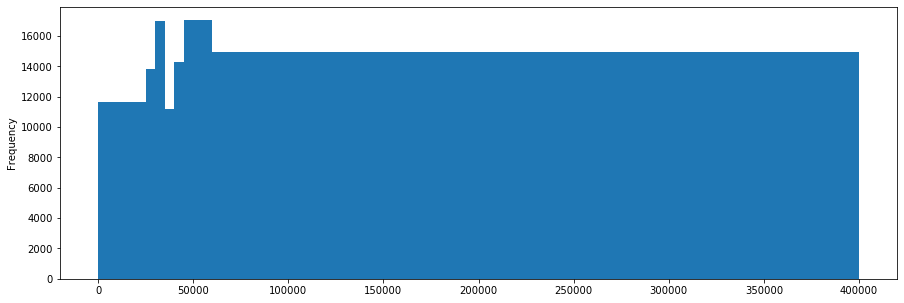

In [13]:
n = 7
bins = []
for i in range(0, n + 1):
    v = df['salary_from'].quantile(i/n)
    bins.append(v)
print(bins)
df['salary_from'].plot.hist(bins=bins, figsize=(15,5))

In [14]:
bins = [0.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 60000.0, 400000.0]
y = []
bins = np.array([0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 60000.0, 400000.0])
for val in df['salary_from']:
    j = 0
    for k in range(0, len(bins)):
        if val < bins[k]:
            j = k
            break
    y.append(k - 1)
y = pd.Series(y)

In [15]:
y.value_counts()

5    17063
2    16996
6    14981
4    14293
1    13832
0    11675
3    11161
dtype: int64

In [16]:
df = pd.concat([df,pd.get_dummies(df['employment'], prefix='employment', drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['schedule'], prefix='schedule', drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['experience'], prefix='experience', drop_first=True)],axis=1)

In [17]:
key_skill_list = []
key_skill_count = []
key_skills = sparse.lil_matrix((10000, len(df)))
for i, row in df.iterrows():
    for skill in row['key_skills'].split(' | '):
        if skill == '':
            continue
        skill = skill.lower()
        if not skill in key_skill_list:
            #print('new skill', skill, len(key_skill_list))
            key_skill_list.append(skill)
            key_skill_count.append(0)
            #key_skills = key_skills.reshape((len(key_skill_list),len(df)))
        skill_index = key_skill_list.index(skill)
        key_skills[skill_index, i] = 1
        key_skill_count[skill_index] += 1
#df['key_skills'].iloc[100]

In [18]:
print([key_skill_list[i] for i in np.array(key_skill_count).argsort()[::-1][0:100]])

['ведение переговоров', 'активные продажи', 'работа в команде', 'пользователь пк', 'телефонные переговоры', 'грамотная речь', 'поиск и привлечение клиентов', 'навыки продаж', 'деловая переписка', 'b2b продажи', 'деловое общение', 'заключение договоров', 'развитие продаж', 'прямые продажи', 'холодные продажи', 'организаторские навыки', 'ответственность', 'коммуникабельность', 'проведение презентаций', 'управление продажами', 'английский язык', 'управление проектами', 'деловая коммуникация', 'планирование продаж', 'стрессоустойчивость', 'ориентация на результат', 'холодные звонки', 'клиентоориентированность', 'навыки презентации', 'javascript', '1с: предприятие 8', 'управление персоналом', 'работа с большим объемом информации', 'html', 'git', 'делопроизводство', 'ms outlook', 'php', 'обучение персонала', 'adobe photoshop', 'css', 'mysql', 'b2c продажи', 'crm', 'autocad', 'подбор персонала', 'грамотность', 'html5', 'руководство коллективом', 'документооборот', 'работа с текущей базой клие

In [19]:
for i in np.array(key_skill_count).argsort()[::-1][0:100]:
    df['skill_' + key_skill_list[i]] = key_skills[i].todense().transpose()
    #print(type(key_skills[i].todense()))

In [20]:
specialization_list = []
specialization_count = []
specializations = sparse.lil_matrix((10000, len(df)))
for i, row in df.iterrows():
    for skill in row['specializations.names'].split(' | '):
        if skill == '':
            continue
        skill = skill.lower()
        if not skill in specialization_list:
            print('new skill', skill, len(specialization_list))
            specialization_list.append(skill)
            specialization_count.append(0)
            #key_skills = key_skills.reshape((len(key_skill_list),len(df)))
        skill_index = specialization_list.index(skill)
        specializations[skill_index, i] = 1
        specialization_count[skill_index] += 1
#df['key_skills'].iloc[100]

new skill маркетинг, реклама, pr - исследования рынка 0
new skill маркетинг, реклама, pr - менеджер по работе с клиентами 1
new skill продажи - менеджер по работе с клиентами 2
new skill продажи - продажи по телефону, телемаркетинг 3
new skill административный персонал - сотрудник call-центра 4
new skill производство - деревообработка, лесная промышленность 5
new skill производство - контроль качества 6
new skill автомобильный бизнес - производство 7
new skill автомобильный бизнес - сервисное обслуживание 8
new skill автомобильный бизнес - автожестянщик 9
new skill автомобильный бизнес - автослесарь 10
new skill страхование - комплексное страхование физических лиц 11
new skill страхование - комплексное страхование юридических лиц 12
new skill страхование - автострахование 13
new skill страхование - агент 14
new skill маркетинг, реклама, pr - производство рекламы 15
new skill маркетинг, реклама, pr - печатная реклама 16
new skill маркетинг, реклама, pr - наружная реклама 17
new skill на

new skill юристы - регистрация юридических лиц 300
new skill юристы - ценные бумаги, рынки капитала 301
new skill юристы - корпоративное право 302
new skill маркетинг, реклама, pr - радио реклама 303
new skill домашний персонал - домработница/домработник, горничная 304
new skill автомобильный бизнес - тонировщик 305
new skill бухгалтерия, управленческий учет, финансы предприятия - аудит 306
new skill туризм, гостиницы, рестораны - швейцар 307
new skill бухгалтерия, управленческий учет, финансы предприятия - финансовый анализ 308
new skill бухгалтерия, управленческий учет, финансы предприятия - финансовый менеджмент 309
new skill продажи - компьютерные программы 310
new skill консультирование - организационное консультирование 311
new skill информационные технологии, интернет, телеком - компьютерная безопасность 312
new skill безопасность - экономическая и информационная безопасность 313
new skill банки, инвестиции, лизинг - инвестиционная компания 314
new skill банки, инвестиции, лизин

new skill закупки - электротехническое оборудование/светотехника 454
new skill закупки - компьютерная техника 455
new skill информационные технологии, интернет, телеком - cto, cio, директор по it 456
new skill банки, инвестиции, лизинг - риски: финансовые 457
new skill юристы - семейное право 458
new skill управление персоналом, тренинги - компенсации и льготы 459
new skill юристы - уголовное право 460
new skill начало карьеры, студенты - наука, образование 461
new skill туризм, гостиницы, рестораны - сомелье 462
new skill банки, инвестиции, лизинг - внутренние операции (back office) 463
new skill туризм, гостиницы, рестораны - организация встреч, конференций 464
new skill рабочий персонал - фасовщик 465
new skill рабочий персонал - перемотчик 466
new skill производство - табачная промышленность 467
new skill наука, образование - экономика, менеджмент 468
new skill консультирование - стратегия 469
new skill высший менеджмент - информационные технологии, интернет, мультимедиа 470
new sk

In [21]:
print([specialization_list[i] for i in np.array(specialization_count).argsort()[::-1][0:100]])

['продажи - розничная торговля', 'продажи - продавец в магазине', 'продажи - менеджер по работе с клиентами', 'продажи - торговые сети', 'продажи - прямые продажи', 'продажи - начальный уровень, мало опыта', 'продажи - оптовая торговля', 'информационные технологии, интернет, телеком - программирование, разработка', 'начало карьеры, студенты - продажи', 'продажи - продукты питания', 'бухгалтерия, управленческий учет, финансы предприятия - бухгалтер', 'продажи - управление продажами', 'строительство, недвижимость - строительство', 'продажи - fmcg, товары народного потребления', 'продажи - продажи по телефону, телемаркетинг', 'транспорт, логистика - автоперевозки', 'административный персонал - секретарь', 'транспорт, логистика - логистика', 'продажи - услуги для бизнеса', 'туризм, гостиницы, рестораны - повар', 'продажи - строительные материалы', 'маркетинг, реклама, pr - менеджер по работе с клиентами', 'информационные технологии, интернет, телеком - инженер', 'транспорт, логистика - вод

In [22]:
for i in np.array(specialization_count).argsort()[::-1][0:100]:
    df['spec_' + specialization_list[i]] = specializations[i].todense().transpose()
    #print(type(key_skills[i].todense()))’

In [23]:
df.shape

(100001, 261)

In [ ]:
df.to_csv('data/vacs_train_features.csv')